<a href="https://colab.research.google.com/github/nabiacrypto/Mentalhealth/blob/main/Transformers_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %%
# Imports for Transformer
import tensorflow as tf
from tensorflow.keras.layers import Layer, MultiHeadAttention, LayerNormalization, Dropout, Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras import activations
from IPython import get_ipython
from IPython.display import display
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import string


import nltk
import re
import warnings

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Import load_model from tensorflow.keras.models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os # Import os module to check for files
import pickle # Import pickle to load the encoder

warnings.filterwarnings('ignore')

# %%
# Check if processed data and model exist
if os.path.exists(X_TRAIN_PATH) and os.path.exists(MODEL_SAVE_PATH) and os.path.exists(LABEL_ENCODER_PATH):
    print("Loading processed data and model from files...")
    try:
        X_train = np.load(X_TRAIN_PATH)
        X_test = np.load(X_TEST_PATH)
        y_train = np.load(Y_TRAIN_PATH)
        y_test = np.load(Y_TEST_PATH)
        model = load_model(MODEL_SAVE_PATH) # Note: You might need custom_objects if using custom layers

        # Load the LabelEncoder
        with open(LABEL_ENCODER_PATH, 'rb') as f:
            encoder = pickle.load(f)

        print("Loaded data and model.")
    except Exception as e:
        print(f"Error loading saved data/model: {e}")
        print("Proceeding with reprocessing and training.")
        # If loading fails, fall through to the 'else' block for reprocessing
        # The else block starts here
        pass # This allows the code to continue to the 'else' block if loading fails

else:
    print("Processed data, model, or encoder not found. Starting preprocessing and training...")
    # %%
    # --- Data Loading and Preprocessing (This part will be skipped if files exist) ---
    # ... (Your data loading and preprocessing code) ...

    # %%
    # Build the Model (This part will also be skipped if files exist and model is loaded)
    # ... (Your model building code - either LSTM/GRU or Transformer) ...

    # %%
    # Train the Model (This part will also be skipped if files exist and model is loaded)
    # ... (Your model training code) ...

    # %%
    # Save processed data and model (This part is only executed after training)
    # ... (Your code to save data and model) ...

# %%
# Check if processed data and model exist
if os.path.exists(X_TRAIN_PATH) and os.path.exists(MODEL_SAVE_PATH) and os.path.exists(LABEL_ENCODER_PATH):
    print("Loading processed data and model from files...")
    try:
        X_train = np.load(X_TRAIN_PATH)
        X_test = np.load(X_TEST_PATH)
        y_train = np.load(Y_TRAIN_PATH)
        y_test = np.load(Y_TEST_PATH)
        model = load_model(MODEL_SAVE_PATH)

        # Load the LabelEncoder
        with open(LABEL_ENCODER_PATH, 'rb') as f:
            encoder = pickle.load(f)

        print("Loaded data and model.")
    except Exception as e:
        print(f"Error loading saved data/model: {e}")
        print("Proceeding with reprocessing and training.")
        # If loading fails, fall through to the 'else' block for reprocessing
        # The else block starts here
        pass # This allows the code to continue to the 'else' block if loading fails

else:
    print("Processed data, model, or encoder not found. Starting preprocessing and training...")
    # %%
    # --- Data Loading and Preprocessing (Keep this block) ---
    df = pd.read_csv('/content/drive/MyDrive/Combined Data.csv')
    # df.head(5) # Optional: display head
    # df.describe(include='all') # Optional: display describe
    # df.info() # Optional: display info
    df = df.drop('Unnamed: 0',axis = 1)

    # Optional: Plot distribution (if you want to see it each time)
    # plt.figure(figsize=(10, 8))
    # sns.countplot(x='status', data=df,palette='YlOrRd')
    # plt.title('label Distribution')
    # plt.show()

    # %%


# %%
# Custom Positional Embedding Layer (Example)
class PositionalEmbedding(Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_embeddings = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embeddings = Embedding(input_dim=sequence_length, output_dim=embed_dim)

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

# %%
# Transformer Encoder Block (Example)
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# %%
# Build the Model (Using Transformer)
# Define Transformer specific parameters
NUM_HEADS = 2  # Number of attention heads
FF_DIM = 32  # Dimension of the feed-forward network

# Ensure MAX_LEN is defined (it should be from your padding)
# VOCAB_SIZE is defined in your existing code

model = Sequential([
    PositionalEmbedding(sequence_length=MAX_LEN, vocab_size=VOCAB_SIZE, embed_dim=64), # Use an embedding dimension
    TransformerEncoder(embed_dim=64, num_heads=NUM_HEADS, ff_dim=FF_DIM),
    # You can add more TransformerEncoder layers if needed
    GlobalAveragePooling1D(),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),
    # Ensure output layer size matches the number of classes
    Dense(len(encoder.classes_), activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Print model summary to verify layers
model.summary()

NameError: name 'X_TRAIN_PATH' is not defined

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Processed data, model, encoder, or tokenizer not found. Starting preprocessing and training...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ positional_embedding_1          │ ?                      │   0 (unbuilt) │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ ?                      │   0 (unbuilt) │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training the model...
Epoch 1/5
929/929 ━━━━━━━━━━━━━━━━━━━━ 100s 101ms/step - accuracy: 0.5787 - loss: 1.1116 - val_accuracy: 0.7463 - val_loss: 0.6650
Epoch 2/5
929/929 ━━━━━━━━━━━━━━━━━━━━ 139s 97ms/step - accuracy: 0.7919 - loss: 0.5574 - val_accuracy: 0.7404 - val_loss: 0.6657
Epoch 3/5
929/929 ━━━━━━━━━━━━━━━━━━━━ 94s 101ms/step - accuracy: 0.8508 - loss: 0.4090 - val_accuracy: 0.7501 - val_loss: 0.7142
Epoch 4/5
929/929 ━━━━━━━━━━━━━━━━━━━━ 141s 99ms/step - accuracy: 0.8808 - loss: 0.3314 - val_accuracy: 0.7366 - val_loss: 0.8185
Epoch 5/5
929/929 ━━━━━━━━━━━━━━━━━━━━ 139s 97ms/step - accuracy: 0.9021 - loss: 0.2724 - val_accuracy: 0.7351 - val_loss: 0.9197
Saving processed data, model, and encoder...


Finished preprocessing and training.
Evaluating the model...
498/498 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.7345 - loss: 0.8969
Test Loss: 0.8895
Test Accuracy: 0.7375
498/498 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step


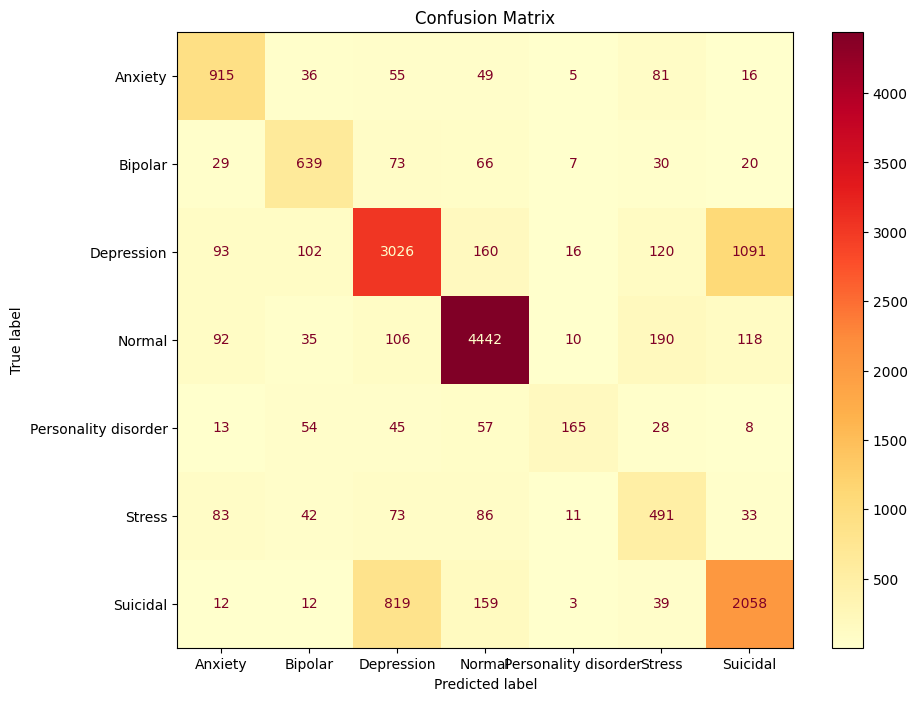


--- Live Sentiment Demo ---
Enter text to predict its sentiment (type 'quit' to exit).
Enter text: i am crying, i want to die
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Sentiment: Suicidal
Enter text: crying out loud
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Sentiment: Normal
Enter text: i did not sleep for two days.i am restless
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted Sentiment: Anxiety
Enter text: I am useless
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Sentiment: Normal
Enter text: i feel like i am under attack
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted Sentiment: Normal
Enter text: Some days I feel like I can conquer the world, but other days I can’t even get out of bed.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Sentiment: Stress


In [ ]:
# %%
from IPython import get_ipython
from IPython.display import display
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import string


import nltk
import re
import warnings

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Import load_model from tensorflow.keras.models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os # Import os module to check for files
import pickle # Import pickle to load the encoder
import tensorflow as tf # Import TensorFlow explicitly for custom layers

warnings.filterwarnings('ignore')

# Download NLTK resources if needed
# Use LookupError when checking if a resource exists locally
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
     nltk.download('punkt')

# Remove the check and download for 'punkt_tab' as it is not a standard resource
# This resource seems to be non-standard and causes an error later.
# Try downloading 'punkt' and 'stopwords' which are standard.
# try:
#     nltk.data.find('tokenizers/punkt_tab')
# except LookupError:
#      print("Warning: 'punkt_tab' not found. This might be a typo or requires a custom download.")
#      pass


# %%
# Define file paths for saving/loading
PROCESSED_DATA_DIR = '/content/drive/MyDrive/processed_data'
MODEL_SAVE_PATH = '/content/drive/MyDrive/transfomers.h5' # Using .h5 format for simplicity
X_TRAIN_PATH = os.path.join(PROCESSED_DATA_DIR, 'X_train.npy')
X_TEST_PATH = os.path.join(PROCESSED_DATA_DIR, 'X_test.npy')
Y_TRAIN_PATH = os.path.join(PROCESSED_DATA_DIR, 'y_train.npy')
Y_TEST_PATH = os.path.join(PROCESSED_DATA_DIR, 'y_test.npy')
LABEL_ENCODER_PATH = os.path.join(PROCESSED_DATA_DIR, 'label_encoder.pkl') # Save the encoder too
# Define Tokenizer path as well, it needs to be saved and loaded for consistent predictions
TOKENIZER_PATH = os.path.join(PROCESSED_DATA_DIR, 'tokenizer.pkl')

# Create the directory if it doesn't exist
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

# Define global preprocessing parameters
VOCAB_SIZE = 10000
MAX_LEN = 100 # Use the length defined later in pad_sequences

# Define clean text functions
def remove_missing_values(df):
    return df.dropna()

def remove_urls(text):
    return re.sub(r'http\S+', '', text)

def remove_mentions(text):
    return re.sub(r'@\w+', '', text)

def remove_emojis(text):
    emoji_pattern = re.compile("[\U00010000-\U0010FFFF]", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_special_chars(text):
    allowed_chars = set(string.ascii_letters + "áéíóúãõàâêôç ")
    return ''.join(c for c in text if c in allowed_chars)

def clean_text(text):
    if not isinstance(text, str):
        return ''

    text = text.lower().strip()
    text = remove_urls(text)
    text = remove_mentions(text)
    text = remove_emojis(text)
    text = remove_special_chars(text)
    text = re.sub(r'\s+', ' ', text)

    return text
nltk.download('punkt_tab')
# Define tokenization and stopword removal function
def tokenize_and_remove_stopwords(text, stopwords_set):
    tokens = word_tokenize(text)
    # Use the stopwords_set for faster lookup
    tokens = [word for word in tokens if word.lower() not in stopwords_set]
    return tokens

# Ensure stopwords are loaded before using them globally
try:
    stopwords_list = stopwords.words('english')
except LookupError:
    print("Downloading stopwords...")
    nltk.download('stopwords')
    stopwords_list = stopwords.words('english')
stopwords_set = set(stopwords_list)


# Custom Positional Embedding Layer (Example) - Define it here as part of the setup
class PositionalEmbedding(Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_embeddings = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embeddings = Embedding(input_dim=sequence_length, output_dim=embed_dim)

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    # Add get_config method for saving/loading custom layers
    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config


# Transformer Encoder Block (Example) - Define it here as part of the setup
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    # Change 'training' from a positional argument to a keyword argument with a default value
    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    # Add get_config method for saving/loading custom layers
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
        })
        return config


# %%
# Check if processed data and model exist
# Combine the loading/training logic into a single block
if os.path.exists(X_TRAIN_PATH) and os.path.exists(MODEL_SAVE_PATH) and os.path.exists(LABEL_ENCODER_PATH) and os.path.exists(TOKENIZER_PATH):
    print("Loading processed data, model, and encoder from files...")
    try:
        X_train = np.load(X_TRAIN_PATH)
        X_test = np.load(X_TEST_PATH)
        y_train = np.load(Y_TRAIN_PATH)
        y_test = np.load(Y_TEST_PATH)

        # Load the LabelEncoder
        with open(LABEL_ENCODER_PATH, 'rb') as f:
            encoder = pickle.load(f)

        # Load the Tokenizer
        with open(TOKENIZER_PATH, 'rb') as f:
            tokenizer = pickle.load(f)

        # Load the model, including custom objects
        model = load_model(MODEL_SAVE_PATH, custom_objects={'PositionalEmbedding': PositionalEmbedding, 'TransformerEncoder': TransformerEncoder})


        print("Loaded data, model, and encoder.")

    except Exception as e:
        print(f"Error loading saved data/model/encoder: {e}")
        print("Proceeding with reprocessing and training.")
        # If loading fails, fall through to the 'else' block for reprocessing
        # The else block starts here
        load_successful = False # Flag to indicate loading failed
        pass # This allows the code to continue to the 'else' block if loading fails
else:
    print("Processed data, model, encoder, or tokenizer not found. Starting preprocessing and training...")
    load_successful = False # Flag to indicate files were not found

# --- Data Loading and Preprocessing / Model Building and Training (Only runs if files weren't loaded) ---
if not load_successful:
    # %%
    # --- Data Loading and Preprocessing ---
    df = pd.read_csv('/content/drive/MyDrive/Combined Data.csv')
    # df.head(5) # Optional: display head
    # df.describe(include='all') # Optional: display describe
    # df.info() # Optional: display info
    df = df.drop('Unnamed: 0',axis = 1)

    # Optional: Plot distribution (if you want to see it each time)
    # plt.figure(figsize=(10, 8))
    # sns.countplot(x='status', data=df,palette='YlOrRd')
    # plt.title('label Distribution')
    # plt.show()

    # %%
    # Clean Text
    # The clean_text function is already defined globally above

    df['statement'] = df['statement'].apply(clean_text)

    # %%
    # Tokenization and Stopword Removal
    # The tokenize_and_remove_stopwords and stopwords_set are already defined globally above

    df['tokenized_statement'] = df['statement'].apply(lambda x: tokenize_and_remove_stopwords(x, stopwords_set))

    # %%
    # Text Vectorization (Tokenization and Padding)
    # Define num_words and maxlen as variables for clarity
    # VOCAB_SIZE and MAX_LEN are defined globally above
    tokenizer = Tokenizer(num_words=VOCAB_SIZE)
    # Fit on the joined tokens for a better vocabulary build
    tokenizer.fit_on_texts([' '.join(tokens) for tokens in df['tokenized_statement']])

    sequences = tokenizer.texts_to_sequences([' '.join(tokens) for tokens in df['tokenized_statement']])

    X = pad_sequences(sequences, padding='post', maxlen=MAX_LEN)

    # %%
    # Label Encoding
    encoder = LabelEncoder()
    # Ensure the column name is correct and consistent
    df['encoded_status'] = encoder.fit_transform(df['status'])
    y = df['encoded_status'] # Assign the encoded column to y

    # %%
    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # %%
    # Build the Model (Using Transformer)
    # Define Transformer specific parameters
    NUM_HEADS = 2  # Number of attention heads
    FF_DIM = 32  # Dimension of the feed-forward network

    # Ensure MAX_LEN and VOCAB_SIZE are defined (they are globally now)

    # Using the custom layers defined above
    model = Sequential([
        PositionalEmbedding(sequence_length=MAX_LEN, vocab_size=VOCAB_SIZE, embed_dim=64), # Use an embedding dimension
        TransformerEncoder(embed_dim=64, num_heads=NUM_HEADS, ff_dim=FF_DIM),
        # You can add more TransformerEncoder layers if needed
        GlobalAveragePooling1D(),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dropout(0.1),
        # Ensure output layer size matches the number of classes
        Dense(len(encoder.classes_), activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    # Print model summary to verify layers
    model.summary()

    # %%
    # Train the Model
    print("Training the model...")
    history = model.fit(
        X_train, y_train,
        epochs=5,
        batch_size=32,
        validation_split=0.2
    )

    # %%
    # Save processed data, model, and encoder
    print("Saving processed data, model, and encoder...")
    np.save(X_TRAIN_PATH, X_train)
    np.save(X_TEST_PATH, X_test)
    np.save(Y_TRAIN_PATH, y_train)
    np.save(Y_TEST_PATH, y_test)
    model.save(MODEL_SAVE_PATH)

    # Save the LabelEncoder
    with open(LABEL_ENCODER_PATH, 'wb') as f:
        pickle.dump(encoder, f)

    # Save the Tokenizer
    with open(TOKENIZER_PATH, 'wb') as f:
        pickle.dump(tokenizer, f)

    print("Finished preprocessing and training.")


# %%
# Evaluate the Model (can be run regardless of whether model was loaded or trained)
print("Evaluating the model...")
# Ensure X_test and y_test are available, either from loading or training
if 'X_test' in locals() and 'y_test' in locals():
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')
else:
    print("Test data not available. Skipping model evaluation.")


# %%
# Display Confusion Matrix (Optional)
# Ensure X_test, y_test, and encoder are available
if 'X_test' in locals() and 'y_test' in locals() and 'encoder' in locals():
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    # Get predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Display confusion matrix
    # Use the classes from the encoder for labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap=plt.cm.YlOrRd)
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("Data or encoder not available for Confusion Matrix display.")


# %%
# Function to preprocess new text data (updated to take stopwords_set)
def preprocess_text_for_prediction(text, tokenizer, maxlen, stopwords_set):
    # Apply the same cleaning steps as used in training
    cleaned_text = clean_text(text) # clean_text is now globally defined

    # Tokenize and remove stopwords
    tokens = word_tokenize(cleaned_text)
    tokens = [word for word in tokens if word.lower() not in stopwords_set]

    # Convert tokens to sequences
    sequence = tokenizer.texts_to_sequences([' '.join(tokens)])

    # Pad the sequences
    padded_sequence = pad_sequences(sequence, padding='post', maxlen=maxlen)

    return padded_sequence

# %%
# Function to make predictions on new text (updated)
def predict_sentiment(text, model, tokenizer, maxlen, encoder, stopwords_set):
    # Preprocess the input text
    processed_text = preprocess_text_for_prediction(text, tokenizer, maxlen, stopwords_set)

    # Make a prediction using the loaded model
    prediction_probs = model.predict(processed_text)
    predicted_class_index = np.argmax(prediction_probs, axis=1)[0]

    # Decode the predicted class index to the original label
    predicted_label = encoder.inverse_transform([predicted_class_index])[0]

    # Return the predicted label and the probabilities for all classes
    return predicted_label, prediction_probs[0]

# %%
# --- Live Demo ---
print("\n--- Live Sentiment Demo ---")
print("Enter text to predict its sentiment (type 'quit' to exit).")

# Ensure tokenizer, encoder, MAX_LEN, and stopwords_set are available
# They should be available if the previous cells ran correctly (either loading or training)
if 'tokenizer' not in locals() or 'encoder' not in locals() or 'MAX_LEN' not in locals() or 'stopwords_set' not in locals():
     print("Required components (tokenizer, encoder, MAX_LEN, stopwords_set) not loaded or created. Cannot run demo.")
else:
    while True:
        user_input = input("Enter text: ")
        if user_input.lower() == 'quit':
            break

        if not user_input.strip():
            print("Please enter some text.")
            continue

        try:
            # Predict the sentiment of the input text
            sentiment, probabilities = predict_sentiment(user_input, model, tokenizer, MAX_LEN, encoder, stopwords_set)
            print(f"Predicted Sentiment: {sentiment}")
            # Optional: Print probabilities for each class
            # print("Probabilities:")
            # for i, label in enumerate(encoder.classes_):
            #     print(f"  {label}: {probabilities[i]:.4f}")

        except Exception as e:
            print(f"An error occurred during prediction: {e}")

    print("Demo finished.")

In [ ]:
# %%
# Function to preprocess new text data
def preprocess_text_for_prediction(text, tokenizer, maxlen, stopwords_set):
    # Apply the same cleaning steps as used in training
    cleaned_text = clean_text(text)

    # Tokenize and remove stopwords
    tokens = word_tokenize(cleaned_text)
    tokens = [word for word in tokens if word.lower() not in stopwords_set]

    # Convert tokens to sequences
    sequence = tokenizer.texts_to_sequences([' '.join(tokens)])

    # Pad the sequences
    padded_sequence = pad_sequences(sequence, padding='post', maxlen=maxlen)

    return padded_sequence

# %%
# Function to make predictions on new text
def predict_sentiment(text, model, tokenizer, maxlen, encoder, stopwords_set):
    # Preprocess the input text
    processed_text = preprocess_text_for_prediction(text, tokenizer, maxlen, stopwords_set)

    # Make a prediction using the loaded model
    prediction_probs = model.predict(processed_text)
    predicted_class_index = np.argmax(prediction_probs, axis=1)[0]

    # Decode the predicted class index to the original label
    predicted_label = encoder.inverse_transform([predicted_class_index])[0]

    return predicted_label

# %%
# --- Live Demo ---
print("\n--- Live Sentiment Demo ---")
print("Enter text to predict its sentiment (type 'quit' to exit).")

# Make sure the tokenizer and stopwords_set are available
# If the model was loaded from disk, you need to create the tokenizer and stopwords_set
# If the model was trained, they are already available
# Create tokenizer if not already created during training (e.g., if model was loaded)
if 'tokenizer' not in locals():
    # Assuming you have access to the original text data or vocabulary
    # For a simple demo, you might need to re-create the tokenizer if it wasn't saved.
    # A robust solution would involve saving and loading the tokenizer along with the model.
    # For this example, we'll assume you can re-create it if needed.
    print("Warning: Tokenizer not found. Re-creating based on vocabulary size.")
    tokenizer = Tokenizer(num_words=VOCAB_SIZE)
    # Note: For a real application, you should save and load the tokenizer.
    # This re-creation is a simplification for the demo.

# Ensure stopwords_set is available
if 'stopwords_set' not in locals():
    try:
        from nltk.corpus import stopwords
        stopwords_set = set(stopwords.words('english'))
    except LookupError:
        print("Downloading stopwords...")
        nltk.download('stopwords')
        from nltk.corpus import stopwords
        stopwords_set = set(stopwords.words('english'))


while True:
    user_input = input("Enter text: ")
    if user_input.lower() == 'quit':
        break

    if not user_input.strip():
        print("Please enter some text.")
        continue

    try:
        # Predict the sentiment of the input text
        sentiment = predict_sentiment(user_input, model, tokenizer, MAX_LEN, encoder, stopwords_set)
        print(f"Predicted Sentiment: {sentiment}")
    except Exception as e:
        print(f"An error occurred during prediction: {e}")

print("Demo finished.")


--- Live Sentiment Demo ---
Enter text to predict its sentiment (type 'quit' to exit).
Enter text: i am dying
An error occurred during prediction: name 'model' is not defined
Enter text: i am crying
An error occurred during prediction: name 'model' is not defined
Enter text: qui
An error occurred during prediction: name 'model' is not defined
Enter text: quit
Demo finished.
